In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
import kuaizi

kuaizi.set_matplotlib(style='JL', usetex=True, fontsize=17, dpi=100)
kuaizi.set_env(project='SBF', name='', data_dir='/scratch/gpfs/JENNYG/jiaxuanl/Data/')

import sys
sys.path.append('/home/jiaxuanl/Research/SBF/src')
sys.path.append('/home/jiaxuanl/Research/SBF/src/SBF')
import artpop
rng = np.random.RandomState(100)

In [2]:
fehs = np.arange(-2, 0.01, 0.25)
log_ages = 9 + np.log10(np.arange(1, 12.1, 1))
feh_age_mesh = np.meshgrid(fehs, log_ages)
print(fehs)
print(log_ages)

[-2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.  ]
[ 9.          9.30103     9.47712125  9.60205999  9.69897     9.77815125
  9.84509804  9.90308999  9.95424251 10.         10.04139269 10.07918125]


In [14]:
len(fehs), len(log_ages)

(9, 12)

In [17]:
from tqdm import trange

In [3]:
from rosesim import Roman_zp_AB_Vega_mist, JWST_zp_AB_Vega

2025-08-12 23:16:47 INFO     Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-08-12 23:16:47 INFO     NumExpr defaulting to 16 threads.


In [18]:
phot_system = 'WFIRST'
iso = artpop.MISTIsochrone(
    log_age = np.log10(1e8),          # log of age in years
    feh = -1.5,             # metallicity [Fe/H]
    phot_system = phot_system, # photometric system(s)
)
bands = iso.filters
print(bands)

['R062', 'Z087', 'Y106', 'J129', 'W146', 'H158', 'F184']


In [19]:
sbf_mag = np.zeros((len(fehs), len(log_ages), len(bands)))
ssp_mag = np.zeros((len(fehs), len(log_ages), len(bands)))

for i in trange(len(fehs)):
    for j in range(len(log_ages)):
        iso = artpop.MISTIsochrone(
            feh = fehs[i],             # metallicity [Fe/H]
            log_age = log_ages[j],          # log of age in years
            phot_system = phot_system, # photometric system(s)
        )
        for k, filt in enumerate(bands):
            sbf_mag[i][j][k] = iso.ssp_sbf_mag(filt)
            ssp_mag[i][j][k] = iso.ssp_mag(filt)
    
np.save('./MIST/WFIRST_sbf_mag.npy', sbf_mag)
np.save('./MIST/WFIRST_ssp_mag.npy', ssp_mag)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:55<00:00, 19.48s/it]


In [35]:
isochrone = 'MIST'
ssp_mag = dict(roman=np.load(f'./{isochrone}/WFIRST_ssp_mag.npy')[:, 2:, :], 
               jwst=np.load(f'./{isochrone}/JWST_ssp_mag.npy')[:, 2:, :])
# JWST is already in AB. See SBF_calib/IR/01_IR_JWST_pred.ipynb

In [36]:
ssp_mag['roman'].shape, ssp_mag['jwst'].shape

((9, 10, 7), (9, 10, 5))

In [37]:
phot_system = 'WFIRST'
iso = artpop.MISTIsochrone(
    log_age = np.log10(1e8),          # log of age in years
    feh = -1.5,             # metallicity [Fe/H]
    phot_system = phot_system, # photometric system(s)
)
bands = iso.filters
print(bands)

for i, filt in enumerate(bands):
    ssp_mag['roman'][..., i] += Roman_zp_AB_Vega_mist[filt]

['R062', 'Z087', 'Y106', 'J129', 'W146', 'H158', 'F184']


In [ ]:
# bands = ['F090W', 'F115W', 'F150W', 'F277W', 'F444W']

In [ ]:
# Y106 = F115 + 0.03
# 

In [84]:
J129 = ssp_mag['roman'][..., 3].ravel()
Y106 = ssp_mag['roman'][..., 2].ravel()
W146 =  ssp_mag['roman'][..., 4].ravel()
H158 = ssp_mag['roman'][..., 5].ravel()
F184 = ssp_mag['roman'][..., 6].ravel()

In [85]:
F115 = ssp_mag['jwst'][..., 1].ravel()
F150 = ssp_mag['jwst'][..., 2].ravel()
F277 = ssp_mag['jwst'][..., 3].ravel()

[0.3510699  0.00826781]


(-2.4671622769447924e-18, 0.00414810863454157)

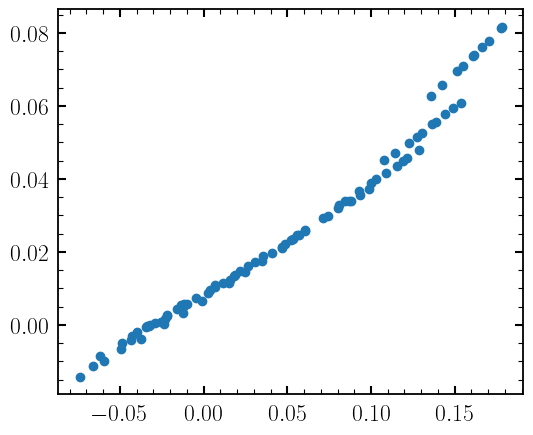

In [86]:
color = F115 - F150

diff = Y106 - F115
plt.scatter(color, diff)

poly = np.polyfit(color, diff, 1)
print(poly)

sct = np.poly1d(poly)(color) - diff
np.mean(sct), np.std(sct)

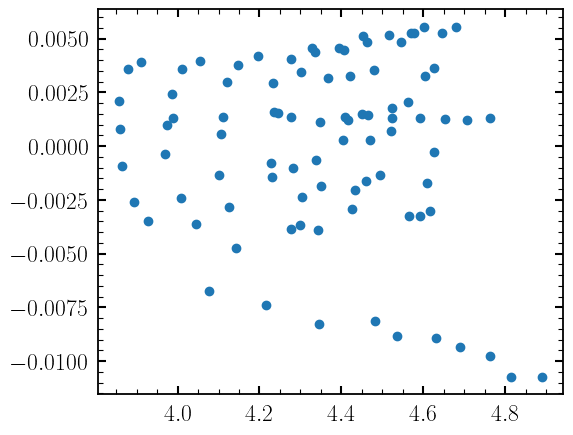

In [88]:
plt.scatter(Y106, np.poly1d(poly)(color) + F115 - Y106)

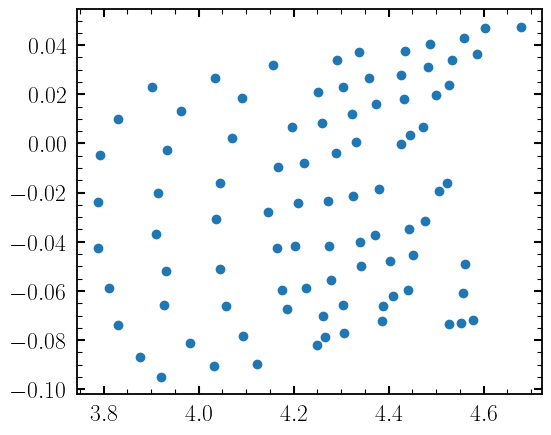

In [48]:
plt.scatter(mag1, mag1 - mag2)

### SBF limit

In [4]:
from rosesim import Roman_zp_AB_Vega_mist, JWST_zp_AB_Vega

In [57]:
phot_system = 'WFIRST'
iso = artpop.MISTIsochrone(
    log_age = np.log10(4e9),          # log of age in years
    feh = -1.5,             # metallicity [Fe/H]
    phot_system = phot_system, # photometric system(s)
)
bands = iso.filters
print(bands)

filters = iso.mag_table.colnames
for filt in filters:
    iso.mag_table[filt] += Roman_zp_AB_Vega_mist[filt]
# now in AB system

['R062', 'Z087', 'Y106', 'J129', 'W146', 'H158', 'F184']


In [58]:
def ssp_sbf_mag(iso, Mabs_thresh, bandpass):
    wght = iso.imf_weights('kroupa')
    flag = iso.mag_table[bandpass] < Mabs_thresh
    lumlum = np.sum(wght[flag] * 10**(-0.8 * iso.mag_table[bandpass][flag]))
    lum = np.sum(wght * 10**(-0.4 * iso.mag_table[bandpass]))
    sbf = -2.5 * np.log10(lumlum / lum)
    return sbf

(-0.01, 0.4)

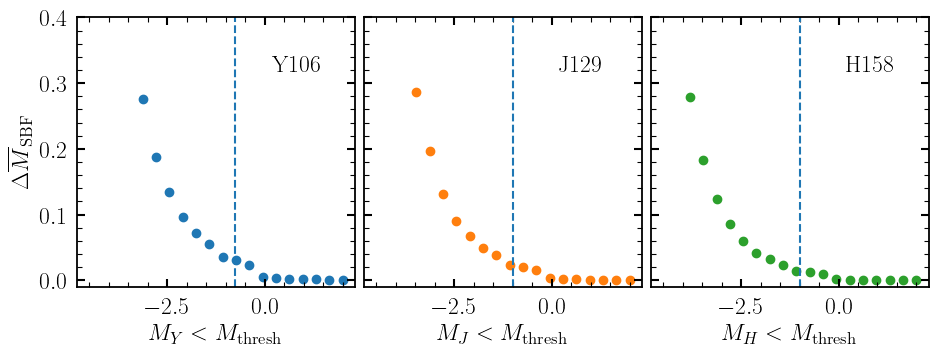

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3.5), sharey=True)
lim_mags = {'Y106': -0.75, 'J129': -1, 'H158': -1}

plt.sca(axes[0])
band = 'Y106'
true_sbf_mag = iso.ssp_sbf_mag(band)
for thresh in np.linspace(-4.5, 2, 20):
    delta = ssp_sbf_mag(iso, thresh, band) - true_sbf_mag
    plt.scatter(thresh, delta, color='C0')
plt.axvline(lim_mags[band], ls='--')
# plt.axvline(lim_mags[band]-0.4, ls=':')
plt.ylabel(r'$\Delta \overline{M}_{\rm SBF}$')
plt.xlabel(r'$M_Y < M_{\rm thresh}$')
plt.text(0.7, 0.8, band, transform=plt.gca().transAxes)

plt.sca(axes[1])
band = 'J129'
true_sbf_mag = iso.ssp_sbf_mag(band)
for thresh in np.linspace(-4.5, 2, 20):
    delta = ssp_sbf_mag(iso, thresh, band) - true_sbf_mag
    plt.scatter(thresh, delta, color='C1')
plt.axvline(lim_mags[band], ls='--')
# plt.axvline(lim_mags[band]-0.4, ls=':')
plt.xlabel(r'$M_J < M_{\rm thresh}$')
plt.text(0.7, 0.8, band, transform=plt.gca().transAxes)

plt.sca(axes[2])
band = 'H158'
true_sbf_mag = iso.ssp_sbf_mag(band)
for thresh in np.linspace(-4.5, 2, 20):
    delta = ssp_sbf_mag(iso, thresh, band) - true_sbf_mag
    plt.scatter(thresh, delta, color='C2')
plt.axvline(lim_mags[band], ls='--')
# plt.axvline(lim_mags[band]-0.4, ls=':')
plt.xlabel(r'$M_H < M_{\rm thresh}$')
plt.text(0.7, 0.8, band, transform=plt.gca().transAxes)

plt.subplots_adjust(wspace=0.03)

plt.ylim(-0.01, 0.4)